<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 3 &ndash; Working with datasets </h2>

<b>Authors:</b> Brandstetter, Rumetshofer, Schörgenhumer<br>
<b>Date:</b> 15-11-2021

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (marked in yellow) which might require small code modifications. Most/All of the used functions are imported from the file <code>u3_utils.py</code> which can be seen and treated as a black box. However, for further understanding you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u3_utils.py</code> need to be installed.

In [1]:
import u3_utils as u3
import numpy as np
import pandas as pd
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.width = 0

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [2]:
u3.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.21.1 (✓)
Installed pandas version: 1.3.1 (✓)
Installed scikit-learn version: 1.0 (✓)
Installed matplotlib version: 3.4.3 (✓)
Installed seaborn version: 0.11.2 (✓)


<h1 style="color:rgb(0,120,170)">Fitting functions</h1>

In Unit 1 we learned about the concepts of features and labels. By downprojecting and clustering features we investigated their correlation and separation power in an unsupervised setting. In this unit we will learn how to apply some supervised machine learning algorithms on them and try to predict the corresponding labels. 

The machine learning algorithms try to find the underlying function that produced the data by training a **model**, often also called **fitting a model to the data**. In real world applications such a model can be quite complex. But before we continue with training a model, we introduce some important concepts that need to be considered.

<h3 style="color:rgb(0,120,170)">Underfitting vs Overfitting</h3>

We now introduce the concepts of **underfitting** and **overfitting**.

Underfitting means that the complexity of the model is too low to figure out all the hidden correlations between data points. Such a model shows pretty poor performance even on the data we use for training, and most likely also on new data not used for training.

Overfitting on the other hand means that the complexity of the model is too high, resulting in a model that learns the training data set by heart (i.e., memorizes each sample and it's corresponding label) instead of learning general structures. It will predict the correct label for samples in the training data but predictions on new and unseen data will be very poor.

We can show these phenomena with a simple function (e.g., a sine curve). 
With this function we generate some data points and then try to fit a model to these points. Hopefully, the model we fit to these datapoints looks like the original sine function. If this is the case we have fitted the model to the data.
In real-life situations we are often given datapoints and have to find the underlying correlations, the underlying functions, the underlying model.

In [3]:
def function(x):
    return np.sin(1.5 * np.pi * x)

We start by evaluating the sine function we defined above at several random points.

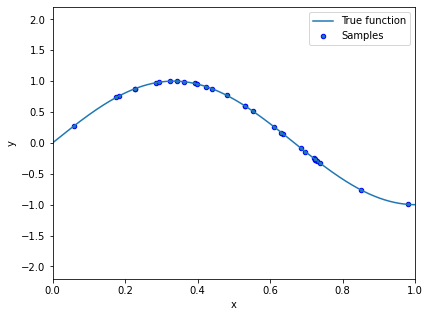

In [4]:
np.random.seed(123)

n_samples = 30
x = np.random.rand(n_samples)
y = function(x)

u3.plot_function(x, y, function)

We notice that every sampled datapoint is exactly a point of the true function. It would be very easy to fit an almost perfect model to these datapoints.

In real-life situations this almost never happens. Instead we get noisy data.
So let's put some random noise on these data points.

Now the datapoints are not perfectly aligned with the function anymore and it is a lot harder to recover the original function just from the datapoints. 

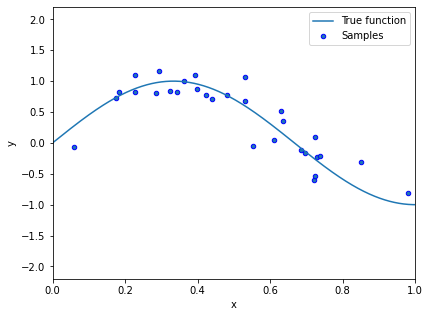

In [5]:
np.random.seed(123)

n_samples = 30
x = np.random.rand(n_samples)
noise = np.random.randn(n_samples) * 0.2
y = function(x) + noise

u3.plot_function(x, y, function)

The next step is to take the noisy data points and to **fit the data points with a polynomial of degree $n$**. 
<br><br> 
Polynomial of degree 1: $a_1\cdot x + c$ <br> 
Polynomial of degree 2: $a_2\cdot x^2 + a_1\cdot x + c$ <br> $\cdots$ <br> $\cdots$ <br> $\cdots$ <br>
Polynomial of degree n: $a_n\cdot x^n + \ldots + a_1\cdot x + c$ <br>

By increasing the degree $n$ we increase the **complexity** of the model, therefore allowing it to fit more complex data.

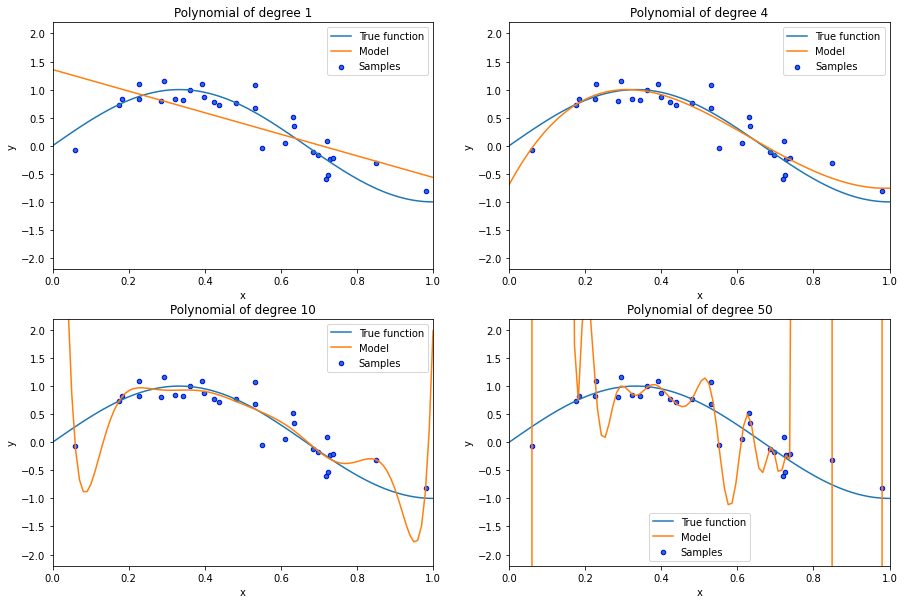

In [6]:
degrees = [1, 4, 10, 50]
u3.plot_polynomial_fit(x, y, function, degrees)

It seems that a polynomial of degree 1 (straight line) cannot fit well to the data (unsurprisingly) as it **underfits** pretty badly. On the other hand, a polynomial of degree 4 does the job pretty well. Polynomials of higher degrees tend to fit to each individual data point and therefore are **prone to overfitting** as we can see on the example of the polynomial with degree 50.

If a model is way too simple to fit the data (e.g., in our case the polynomial of degree 1), we say that this model has a **high bias**. It will perform equally bad on the training data and on new data we get in the future. It has a systematic error due to its low complexity. 

On the other hand, if the model is too complex, it will exactly fit the training data, which is noisy, disregarding the underlying structure of the data. For example, the polynomial of degree 50 nearly fits every data point exactly but makes nonsensical, highly varying predictions in-between. We say the model has **high variance**.

The holy grail in machine learning is to find the correct **bias-variance trade-off**.

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Come up with your own function you want to fit. </li>
        <li>Change the number of sampled points and decrease/increase the noise you put on these points. </li>
        <li>Try out polynomials of different degrees. Can you fit your sampled data points?</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">Training a more complex model</h1>

Before we can start with training a more complex model, we first need a dataset. As you are already familiar with the [Wine dataset](https://archive.ics.uci.edu/ml/index.php) from Unit 1 we will stick to that. In the following you see a short recap of the dataset:

The dataset consists of 178 samples. Every sample comprises thirteen features as floating point numbers representing measurements from a chemical analysis. We have the following $d=13$ features:

- alcohol
- malic acid
- ash
- alcalinity of ash  
- magnesium
- total phenols
- flavanoids
- nonflavanoid phenols
- proanthocyanins
- color intensity
- hue
- OD280/OD315 of diluted wines
- proline  

Furthermore, for our labels we distinguish three different classes refering to the type of cultivator. Our samples ($n=178$) belong to one out of three different classes, namely:

- Cultivator 0 ($n_{c0}=59$)
- Cultivator 1 ($n_{c1}=71$)
- Cultivator 2 ($n_{c2}=48$).

These are stored in the class label column `cultivator`.

In [7]:
# load the wine dataset and look at the data (feature columns + label column)
wine = u3.load_wine()
wine

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,cultivator
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


<h3 style="color:rgb(0,120,170)">Dimensionality reduction</h3>

To inspect the dataset further we downproject the data with PCA to two dimensions and look for clusters. We see that the three different cultivators are already in different regions of the downprojected space but not perfectly separated. 

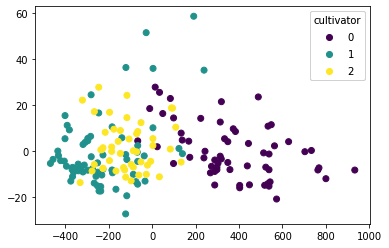

In [8]:
wine_pca = u3.apply_pca(n_components=2, data=wine, target_column='cultivator')
u3.plot_points_2d(data=wine_pca, target_column='cultivator')

<h3 style="color:rgb(0,120,170)">Data split</h3>

For training a model, we have to split our data into a **training set** and into a **test set**. The training set will be used (as the name suggests) for training the model, the test set (as the name also suggests) will be used for testing the model on unseen data. Here, unseen means that the data has not been used for training and we can therefore get a feeling of how good our classifier performs on new data.

We now divide the data set between the training set and the test set in the **ratio 3:1**. This is the standard ratio of the method *train_test_split*, you can later try to modify it. Note that the train-test split is performed randomly by shuffling the data, then keeping the indicated fraction (`test_size`) for testing and the remainder for training. Therefore, it is unlikely that we obtain the same training or test data sets again, unless we specify the seed of the pseudo-random number generator as done here (`random_state`).

In [9]:
# given the entire wine data, separate features X (feature vector matrix) and labels y (label vector)
feature_names = wine.columns[:-1]  # ".columns" accesses the column names and [:-1] means to extract every name up until the last one (the "cultivator" class label column)
X = wine[feature_names]  # this selects all the feature data from our entire wine data
y = wine['cultivator']  # this selects the class labels from our entire wine data

# split X and y in train and test set (default is 75% / 25% train-test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [9]:
# use a subset of our 13 features for better visualization
feature_names_subset = ['alcohol', 'flavanoids', 'color_intensity']
u3.plot_features(X=X_train, y=y_train, features=feature_names_subset)

NameError: name 'X_train' is not defined

And here is the same visualization for the test set. As you can see it looks very similar to the training set above.

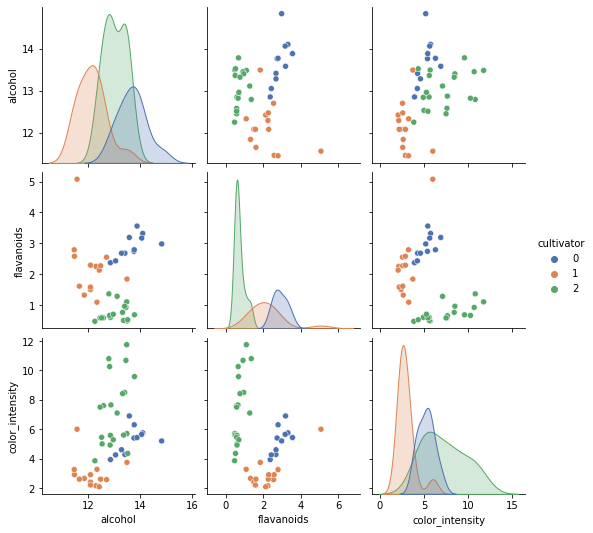

In [11]:
u3.plot_features(X=X_test, y=y_test, features=feature_names_subset)

<h3 style="color:rgb(0,120,170)">$k$-nearest neighbors, the first machine learning algorithm</h3>

Now we want to train our first machine learning alorithm. The **$k$-nearest neighbors** classifier assigns class values according to the class that occurs most often among $k$ samples closest to the datapoint $\boldsymbol{x}$.
![](./resources/kNN_sketch.png) 

The only important parameter for the method is the number of neighbors `n_neighbors` (i.e., $k$) which determines how many samples will be taken into account for obtaining the class of an input sample. To train and test the model we use the data set split from above with a reduced number of features. The $k$-nearest neighbors classifier is trained using the `fit` method and tested (on some test set) using the `score` method. 

To simplify the dataset, out of the $13$ features of our dataset we select those we think are most informative. Later you will choose different features and see how that influences the performance of your trained model.

In [12]:
feature_names_subset = ['alcohol', 'flavanoids', 'color_intensity']

X_train_subset = X_train[feature_names_subset]
X_test_subset = X_test[feature_names_subset]

# train the model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_subset, y_train)

# use the trained model
print('Accuracy on training set: {:.4f}'.format(knn.score(X_train_subset, y_train)))
print('Accuracy on     test set: {:.4f}'.format(knn.score(X_test_subset, y_test)))

Accuracy on training set: 0.9474
Accuracy on     test set: 0.9556


As you can see the accuracy on the test set is not too far off the accuracy on the training set (sometimes even a bit higher, but this is an effect of the smaller test set). Therefore, the model is not overfitting on the training data.

Let's now "invent" two new samples and see which of the three cultivators our trained $k$-nearest neighbor classifier thinks produced these two wine samples by using the method `predict`. Be aware that we used only three features for training and therefore can only these three features to describe our new samples (you will get an error otherwise). For our new samples we define the following values:
- Sample 1: alcohol $13.59$, flavanoid $3.12$ and color_intensity $6.38$
- Sample 2: alcohol $12.97$, flavanoid $1.04$ and color_intensity $13.73$

In [13]:
new_samples = [  # list of samples
    [13.59, 3.12, 6.38],  # sample 1
    [12.97, 1.04, 13.73],  # sample 2
]
wine_predictions = knn.predict(new_samples)

print("The k-nearest neighbors classifier predicts classes {}".format(wine_predictions))

The k-nearest neighbors classifier predicts classes [0 2]


As we can see, a trained classifier does not only work on the points used for training (or testing) but on every point in the input space. Next, we therefore have a look how any point would be classified (for visualization purposes we only use two features here). The borders between the different classification regions are called **decision boundaries**.

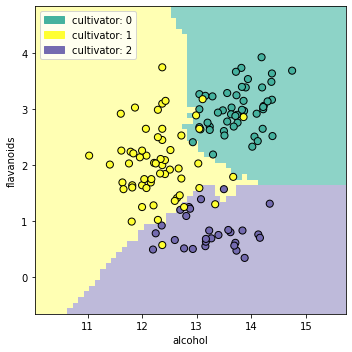

In [14]:
feature_names_subset = ['alcohol', 'flavanoids']
knn = KNeighborsClassifier(n_neighbors=5)
u3.plot_decision_boundaries(knn, X_train, y_train, feature_names_subset)

<h4 style="color:rgb(0,120,170)">Train with all features</h4>

So far we have simplified the problem by manually choosing features we know are very informative (i.e., they make it easy to separate the samples). But in practice we often don't know this and for datasets with several thousand features it's not so easy to find those features (or more likely the right combination of features).
Therefore, we will now train the $k$-nearest neighbors classifier with all 13 features and see how this influences the accuracy.

In [15]:
knn.fit(X_train, y_train)

print('Accuracy on training set: {:.4f}'.format(knn.score(X_train, y_train)))
print('Accuracy on     test set: {:.4f}'.format(knn.score(X_test, y_test)))

Accuracy on training set: 0.7895
Accuracy on     test set: 0.6444


We can see that the accuracy is now **lower on both** the training and on the test set. This indicates that the $k$-nearest neighbors classifier is **underfitting** and not able to fit such complex data.
Often it will be a lot **lower on the test set** than on the training set (sometimes up to 20%), indicating that the model is **overfitting** on the training data. 

Here we see a case of a model both **underfitting** and **overfitting**, i.e., the model is not able to completely figure out the underlying function of the data (which is highly complex) but it can memorize individual samples of the training set.

<h4 style="color:rgb(0,120,170)">Hyperparameters</h4>

For some models (like the polynomials in the beginning) the complexity of the model can be increased via hyper-parameters (i.e., parameters of the model class that can be tuned). So, let's try this for our $k$-nearest neighbors classifier by changing $k$.

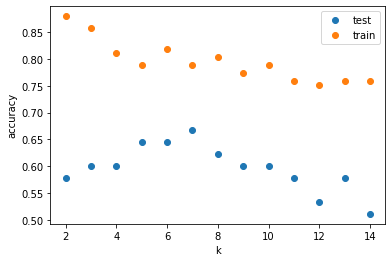

In [16]:
k_range = range(2, 15)  # creates a range of consecutive numbers starting from 2 up to 15 exclusive = [2, 3, ..., 13, 14]
u3.test_k_range(X_train, y_train, X_test, y_test, k_range)

We can see that the number of neighbors $k$ has some influence on the performance of our model.

<h3 style="color:rgb(0,120,170)">Tasks </h3>
<div class="alert alert-warning">
    <ul>
        <li>Test different train-test splits (ratios) and plot the scatter matrices.
        <li>Train the $k$-nearest neighbors classifier with different feature variables (names and number of variables). What is the best score on the test set you can get? </li>
        <li>Obtain the decision boundaries for different combinations of two feature variables. You can use any of the thirteen feature variables. What is the best separation you can get? </li>
        <li>Play around with the range of $k$ neighbors and the train-test split ratio. Which correlations do you observe?</li>
    </ul>
</div>

<h3 style="color:rgb(0,120,170)">Test another classifier</h3>

We have seen that the $k$-nearest neighbors classification method does not perform extremely well on our dataset if we use all features instead of pre-selecting only the "good" ones. We now look how another method, namely **Random Forest** performs.
In the following, we train the Random Forest classifier and have a closer look on how it performs if we use all features.
`n_estimators` specifies the number of internal decision trees.

If you want reproducible results, you have to set `random_state` again.

In [17]:
clf = RandomForestClassifier(n_estimators=5, random_state=123)
clf.fit(X_train, y_train)

print('Accuracy on training set: {:.4f}'.format(clf.score(X_train, y_train)))
print('Accuracy on     test set: {:.4f}'.format(clf.score(X_test, y_test)))

Accuracy on training set: 1.0000
Accuracy on     test set: 0.9333


We can see that the RF classifier performs a lot better, both on the training and on the test set, than the $k$-nearest neighbors classifier even when we use all features. This classifier has as hyper-parameter the number of estimators (the number of "trees" in the forest) it is allowed to use.

Similar to the k-NN classifier we can also evaluate the random forest classifier on all datapoints in a grid and visualize the decision boundaries. However, we have to limit our features as we can only visualize this for two features (but we show several feature combinations). 

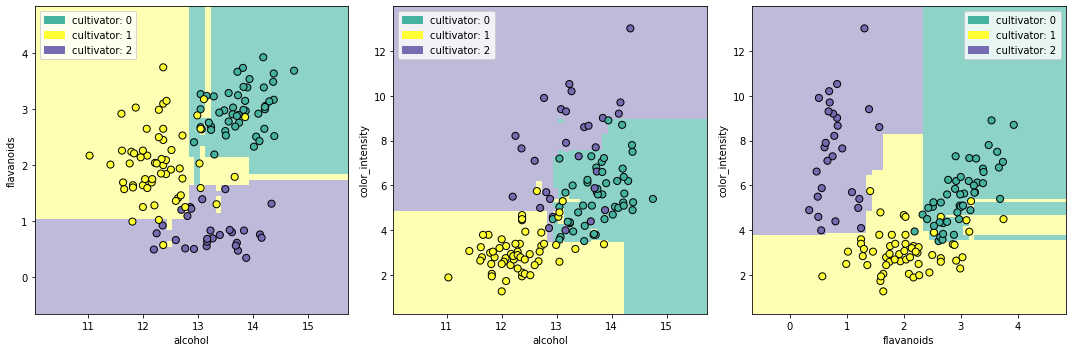

In [18]:
feature_pairs = [
    ['alcohol', 'flavanoids'],
    ['alcohol', 'color_intensity'],
    ['flavanoids', 'color_intensity']
]
classifier = RandomForestClassifier(n_estimators=5, random_state=123)
u3.plot_decision_boundaries(classifier, X_train, y_train, feature_pairs)

<h3 style="color:rgb(0,120,170)">Tasks </h3>
<div class="alert alert-warning">
    <ul>
        <li>Test different numbers of estimators for the Random Forest Classifier. What do you observe?
    </ul>
</div>